In [1]:
from astropy.table import QTable, join, Table, vstack
from gala.coordinates import reflex_correct
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
plt.style.use('seaborn')
import astropy.coordinates as coord
import astropy.units as u
import gala.coordinates as gc
from scipy.ndimage import gaussian_filter

In [376]:
def getDust(G, bp, rp, ebv, maxnit=10):
    """ Compute the Gaia extinctions assuming relations from Babusieux
    Arguments: G, bp, rp, E(B-V)
    maxnit -- number of iterations
    Returns extinction in G,bp, rp
    Author: Sergey Koposov skoposov@cmu.edu
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        #print(scipy.stats.scoreatpercentile(delta[np.isfinite(delta)], 99))
        curbp = curbp1
    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


## Read in the PanStarrs, Shmash and Sesar2013 data

In [2]:
data = QTable.read('RRLyrae_PS1_GDR2.fits')

In [3]:
smhashData = Table.read('smhash_orphan_rrly.txt', format='ascii')

In [4]:
sesarData = Table.read('apj483401t1and3_mrt.txt', format='ascii')

In [5]:
#ssData = join(smhashData, sesarData, keys='Name')
ssData = join(sesarData, smhashData, keys='Name', join_type='outer')

In [6]:
ssData = ssData[ssData['Mem'] == 'high']

### Generate coord object for Shmash + Sesar2013 RR lyrae and rotate into Orphan frame and plot things

Text(0,0.5,'Sesar2013  Distance [kpc]')

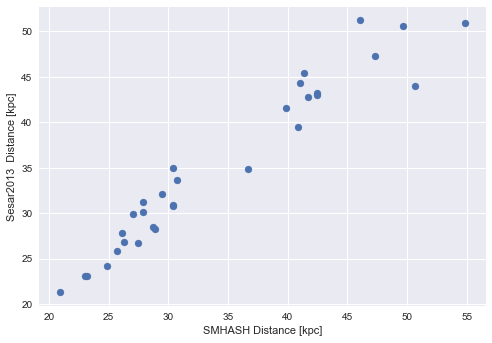

In [7]:
#which distances should I use? 
plt.scatter(ssData['HDis_1'], ssData['HDis_2'])
plt.xlabel('SMHASH Distance [kpc]')
plt.ylabel('Sesar2013  Distance [kpc]')

In [8]:
ssEq = coord.SkyCoord(ra  = ssData['RAdeg_1'],
                     dec = ssData['DEdeg_1'], 
                     distance = ssData['HDis_1'])
ssGal = ssEq.transform_to(coord.Galactic)

In [9]:
cSSGal = coord.Galactic(l=ssGal.l, b = ssGal.b, 
                     pm_l_cosb = ssData['pml'],
                     pm_b = ssData['pmb'], 
                     distance = ssGal.distance,
                     radial_velocity = ssData['VHel'])
cSS = cSSGal.transform_to(coord.ICRS)
cSS = reflex_correct(cSS)


In [10]:
orphSS = cSS.transform_to(gc.Orphan)

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


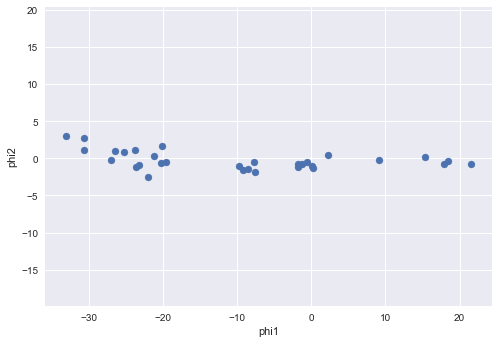

In [11]:
plt.scatter(orphSS.phi1.wrap_at(180*u.deg), orphSS.phi2)
plt.xlabel('phi1')
plt.ylabel('phi2')
plt.axes().set_aspect('equal', 'datalim')

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


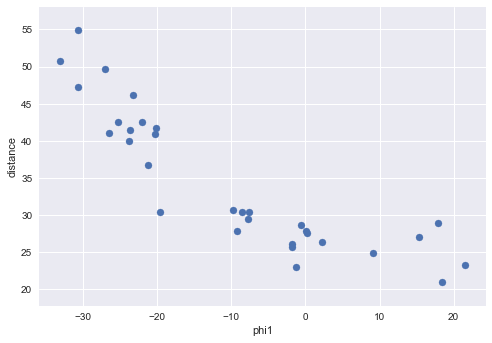

In [12]:
plt.scatter(orphSS.phi1.wrap_at(180*u.deg), orphSS.distance)
plt.xlabel('phi1')
plt.ylabel('distance')
plt.axes().set_aspect('equal', 'datalim')

Text(0.5,1,'Reflex Corrected Radial Velocities')

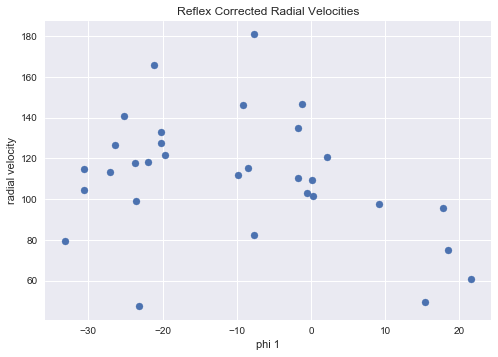

In [13]:
plt.scatter(orphSS.phi1.wrap_at(180*u.deg), orphSS.radial_velocity)
plt.xlabel('phi 1')
plt.ylabel('radial velocity')
plt.title('Reflex Corrected Radial Velocities')

### Generate coord object for PanStarrs and xmatch with Shmash + Sesar2013 data

In [14]:
#choose reasonable thresholds, for now I'm including everything 
P_rrlyrae_threshold = 0.8
pmerror_threshold = 1*u.mas/u.yr

wantedRRlyrae = ~np.isnan(data['pmra']) & \
       ~np.isnan(data['pmdec']) & \
       (data['RRab'] > P_rrlyrae_threshold) & \
       (data['pmra_error'] < pmerror_threshold) & \
       (data['pmdec_error']< pmerror_threshold)

/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [15]:
distance = 10.**(0.2*data['DM'] + 1)/1000

In [16]:
c = coord.SkyCoord(ra=data['ra_1a'][wantedRRlyrae], 
                   dec=data['dec_1a'][wantedRRlyrae], 
                   pm_ra_cosdec=data['pmra'][wantedRRlyrae],
                   pm_dec=data['pmdec'][wantedRRlyrae],
                   distance = distance[wantedRRlyrae]*u.kpc, 
                   radial_velocity=0.*u.km/u.s)
c = reflex_correct(c)
cGal = c.transform_to(coord.Galactic)
cGalactic = c.transform_to(coord.Galactic)
cGal.set_representation_cls('cartesian')

orphPan = c.transform_to(gc.Orphan)

In [17]:
idx, d2d, d3d = cSS.match_to_catalog_sky(c)  

In [18]:
print(len(idx))

31


Text(0,0.5,'probability of being RRab')

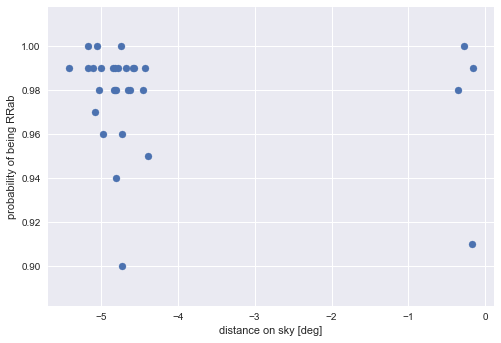

In [19]:
plt.scatter(np.log10(d2d.value), data[wantedRRlyrae][idx]['RRab'])
plt.xlabel('distance on sky [deg]')
plt.ylabel('probability of being RRab')


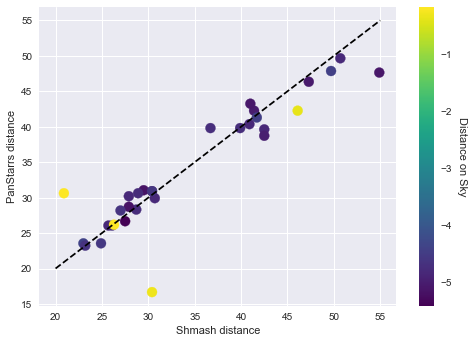

In [20]:
plt.scatter(cSS.distance, c[idx].distance, c=np.log10(d2d.value), s=100, cmap=plt.get_cmap('viridis'))
cbar = plt.colorbar()
plt.xlabel('Shmash distance')
plt.ylabel('PanStarrs distance')
plt.plot([20, 55], [20, 55], 'k--')
cbar.set_label('Distance on Sky', rotation=270, labelpad=15)


### Grab only stars close on sky

In [21]:
#idx = idx[d2d < 1*u.arcsec]
#cSS = cSS[d2d < 1*u.arcsec]
#c[idx], ssData[d2d < 1*u.arcsec]

Text(0,0.5,'pm phi2')

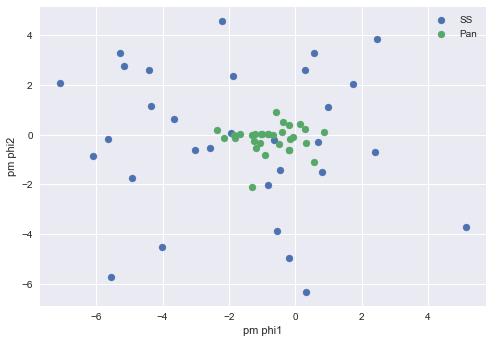

In [22]:
plt.scatter(orphSS.pm_phi1_cosphi2, orphSS.pm_phi2, label='SS')
plt.scatter(orphPan[idx].pm_phi1_cosphi2, orphPan[idx].pm_phi2, label='Pan')
plt.legend()
plt.xlabel('pm phi1')
plt.ylabel('pm phi2')

Text(0.5,1,'PM Error ~ PM')

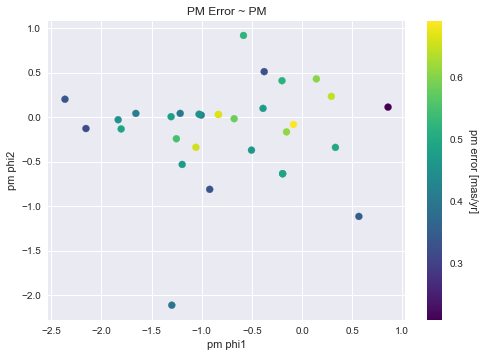

In [23]:
pm_error = np.sqrt(data[wantedRRlyrae][idx]['pmra_error']**2. + 
          data[wantedRRlyrae][idx]['pmdec_error']**2.)
plt.scatter(orphPan[idx].pm_phi1_cosphi2, orphPan[idx].pm_phi2, c=pm_error, cmap=plt.get_cmap('viridis'))
cbar = plt.colorbar()
cbar.set_label('pm error [mas/yr]', rotation=270, labelpad=15)
plt.xlabel('pm phi1')
plt.ylabel('pm phi2')
plt.title('PM Error ~ PM')

Text(0,0.5,'pm phi2')

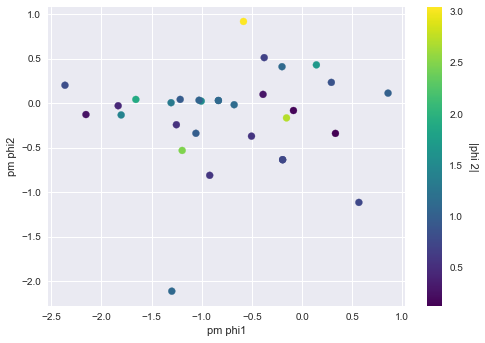

In [24]:
plt.scatter(orphPan[idx].pm_phi1_cosphi2, orphPan[idx].pm_phi2, 
            c=np.abs(orphPan[idx].phi2), cmap=plt.get_cmap('viridis'))
cbar = plt.colorbar()
cbar.set_label('|phi 2|', rotation=270, labelpad=15)
plt.xlabel('pm phi1')
plt.ylabel('pm phi2')

Text(0,0.5,'pm phi2')

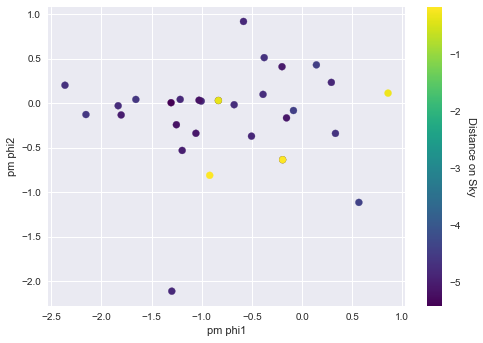

In [25]:
plt.scatter(orphPan[idx].pm_phi1_cosphi2, orphPan[idx].pm_phi2, 
            c=np.log10(d2d.value), cmap=plt.get_cmap('viridis'))
cbar = plt.colorbar()
cbar.set_label('Distance on Sky', rotation=270, labelpad=15)

plt.xlabel('pm phi1')
plt.ylabel('pm phi2')


## Generate mega coord object with 6D phase information

In [26]:
cAll = coord.SkyCoord(ra            = data[wantedRRlyrae][idx]['ra_1a'], 
                      dec           = data[wantedRRlyrae][idx]['dec_1a'],
                      pm_ra_cosdec  = data[wantedRRlyrae][idx]['pmra'],
                      pm_dec        = data[wantedRRlyrae][idx]['pmdec'],
                      distance      = distance[wantedRRlyrae][idx]*u.kpc,
                      radial_velocity = ssData['VHel'])
cAll = reflex_correct(cAll)
cAllGal = cAll.transform_to(coord.Galactic)
cAllGalactic = cAll.transform_to(coord.Galactic)
cAllGal.set_representation_cls('cartesian')

orphAll = cAll.transform_to(gc.Orphan)

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'rad v error [km/s]')

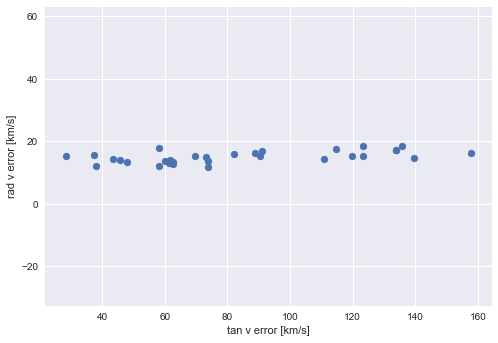

In [27]:
pmerror_1 = (data[wantedRRlyrae][idx]['pmra_error']**2. + 
          data[wantedRRlyrae][idx]['pmdec_error']**2.)*(distance[wantedRRlyrae][idx]*u.kpc)**2.
pmerror_2 = (data[wantedRRlyrae][idx]['pmra']**2. + 
          data[wantedRRlyrae][idx]['pmdec']**2.)*(0.08*distance[wantedRRlyrae][idx]*u.kpc)**2.
pmerror = np.sqrt(pmerror_1 + pmerror_2).to(u.km/u.s, u.dimensionless_angles())
plt.scatter(pmerror, ssData['e_VHel'])
plt.axes().set_aspect('equal', 'datalim')
plt.xlabel('tan v error [km/s]')
plt.ylabel('rad v error [km/s]')

Text(0.5,0,'distance [kpc]')

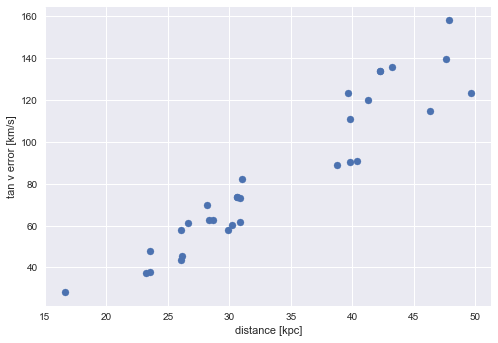

In [28]:
plt.scatter(distance[wantedRRlyrae][idx], pmerror)
plt.ylabel('tan v error [km/s]')
plt.xlabel('distance [kpc]')

Text(0.5,1,'Reflex Corrected Radial Velocities')

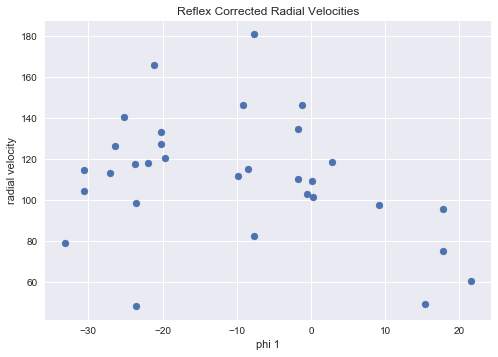

In [29]:
plt.scatter(orphAll.phi1.wrap_at(180*u.deg), orphAll.radial_velocity)
plt.xlabel('phi 1')
plt.ylabel('radial velocity')
plt.title('Reflex Corrected Radial Velocities')

## With 6D phase information, let's try to fit an orbit

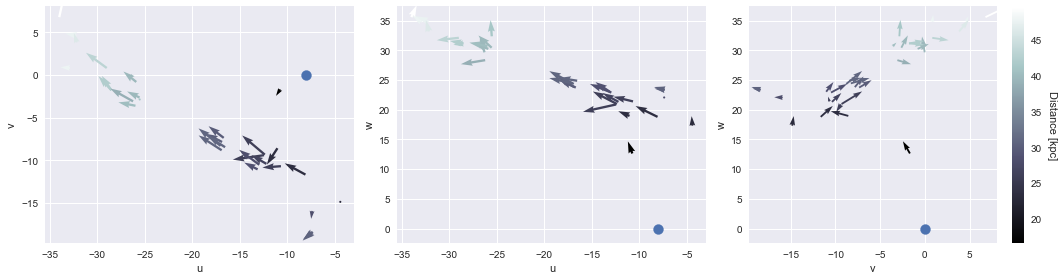

In [391]:
norm = mpl.colors.Normalize()
norm.autoscale(cAll.distance.value)
cm = mpl.cm.bone

sm = mpl.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].quiver(cAllGal.u, cAllGal.v, cAllGal.U, cAllGal.V, color=cm(norm(cAll.distance.value)))
ax[0].scatter(-8, 0, s=100)
ax[0].set_xlabel('u'); ax[0].set_ylabel('v')
ax[1].quiver(cAllGal.u, cAllGal.w, cAllGal.U, cAllGal.W, color=cm(norm(cAll.distance.value)))
ax[1].scatter(-8, 0, s=100)
ax[1].set_xlabel('u'); ax[1].set_ylabel('w')
im = ax[2].quiver(cAllGal.v, cAllGal.w, cAllGal.V, cAllGal.W, color=cm(norm(cAll.distance.value)))
ax[2].scatter(0, 0, s=100)
ax[2].set_xlabel('v'); ax[2].set_ylabel('w')
cbar = fig.colorbar(sm) #, ax=ax.ravel().tolist()) #, ax=ax.ravel().tolist())
cbar.set_label('Distance [kpc]', rotation=270, labelpad=15)
plt.tight_layout()
fig.savefig('orphan6d.jpg')
#fig.colorbar(im, ax=axes.ravel().tolist())

In [31]:
%matplotlib inline

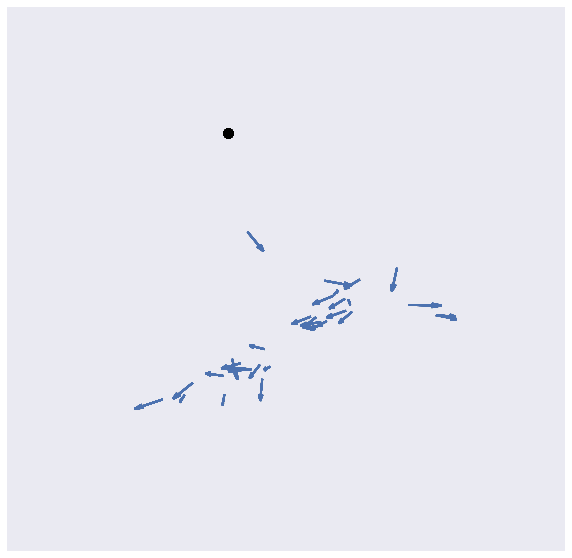

In [32]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_axis_off()
#for phi in [0]:
for phi in np.linspace(0, 360.0001, 32):
    for theta in [0]:
    #for theta in np.linspace(0, 360.001, 32):
        ax.view_init(phi, theta)
        m = ax.quiver(cAllGal.u, cAllGal.v, cAllGal.w, 
          cAllGal.U, cAllGal.V, cAllGal.W, 
          normalize=True, length=3)
        ax.scatter(-8, 0, 0, s=100, c='black')
        ax.set_xlabel('u')
        ax.set_ylabel('v')
        ax.set_zlabel('w')
        #m.set_rasterized(True)
        fig.savefig('orphan_{0:03d}_{1:03d}.pdf'.format(int(phi), int(theta)))


## Play around with extending the stream in PanStarrs
## Take advantage of the information we already know about Orphan

In [33]:
#boxy determinations of stream 
distance_min = 10*u.kpc
phi1_lim = 100*u.deg
phi2_lim = 10.0*u.deg
offstream_deltaphi2 = 5*u.deg
pm_phi1_min = -4*u.mas/u.yr
pm_phi1_max = 2*u.mas/u.yr
pm_phi2_lim = 2*u.mas/u.yr
stream = (np.abs(orphPan.phi2) <= phi2_lim) & \
         (orphPan.distance > distance_min) & \
         (np.abs(orphPan.phi1.wrap_at(180*u.deg)) < phi1_lim) & \
         (np.abs(orphPan.pm_phi2) < pm_phi2_lim) & \
         (orphPan.pm_phi1_cosphi2 > pm_phi1_min) & \
         (orphPan.pm_phi1_cosphi2 < pm_phi1_max)

offstream = (np.abs(orphPan.phi2) > phi2_lim) & \
            (np.abs(orphPan.phi2) < phi2_lim + offstream_deltaphi2) & \
            (orphPan.distance > distance_min) & \
            (np.abs(orphPan.phi1.wrap_at(180*u.deg)) < phi1_lim)

In [34]:
#fit 2nd and 3rd order polynomials to phi1, phi2 and distance
f2phi2 = np.poly1d(np.polyfit(orphAll.phi1.wrap_at(180*u.deg), orphAll.phi2, 2))
f3phi2 = np.poly1d(np.polyfit(orphAll.phi1.wrap_at(180*u.deg), orphAll.phi2, 3))

f2d = np.poly1d(np.polyfit(orphAll.phi1.wrap_at(180*u.deg), orphAll.distance, 2))
f3d = np.poly1d(np.polyfit(orphAll.phi1.wrap_at(180*u.deg), orphAll.distance, 3))

In [35]:
streamPlay = (np.abs(f2phi2(orphPan.phi1.wrap_at(180*u.deg)) - orphPan.phi2.value) < 3) & \
             (np.abs(f2d(orphPan.phi1.wrap_at(180*u.deg)) - orphPan.distance.value) < 10)

xphi1 = np.linspace(-100, 100, 100)
c_known = 'black'
c_all = 'C0'
c_play = 'C2'

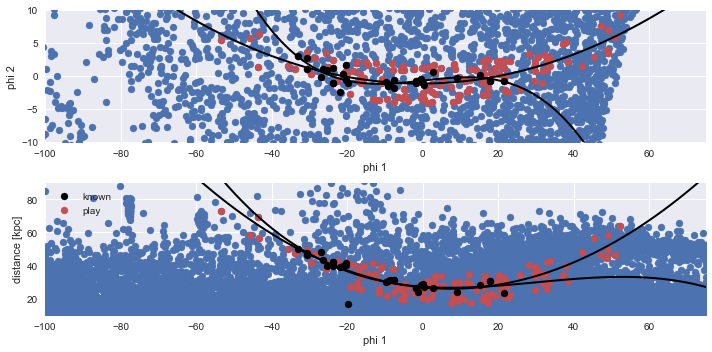

In [36]:
fig, ax = plt.subplots(2, figsize=(10, 5))
ax[0].scatter(orphPan.phi1.wrap_at(180*u.deg), orphPan.phi2, c=c_all)
ax[0].scatter(orphAll.phi1.wrap_at(180*u.deg), orphAll.phi2, label='known', zorder=10, c=c_known)
ax[0].scatter(orphPan.phi1[streamPlay].wrap_at(180*u.deg), orphPan.phi2[streamPlay], zorder=9, label='play', c=c_play)
ax[0].plot(xphi1, f2phi2(xphi1), linewidth=2, color='black', zorder=11)
ax[0].plot(xphi1, f3phi2(xphi1), linewidth=2, color='black', zorder=12)

ax[1].scatter(orphPan.phi1.wrap_at(180*u.deg), orphPan.distance, c=c_all)
ax[1].scatter(orphAll.phi1.wrap_at(180*u.deg), orphAll.distance, label='known', zorder=10, c=c_known)
ax[1].scatter(orphPan.phi1[streamPlay].wrap_at(180*u.deg), orphPan.distance[streamPlay], label='play', zorder=9, c=c_play)
ax[1].plot(xphi1, f2d(xphi1), linewidth=2, color='black', zorder=11)
ax[1].plot(xphi1, f3d(xphi1), linewidth=2, color='black', zorder=12)

plt.legend()
ax[1].set_xlabel('phi 1')
ax[1].set_ylabel('distance [kpc]')
ax[1].set_ylim(distance_min.value, 90)
ax[1].set_xlim(-phi1_lim.value, 75)


#plt.axes().set_aspect('equal')
plt.legend()
ax[0].set_xlabel('phi 1')
ax[0].set_ylabel('phi 2')
ax[0].set_xlim(-phi1_lim.value, 75)
ax[0].set_ylim(-phi2_lim.value, phi2_lim.value)

plt.tight_layout()

(-3, 2)

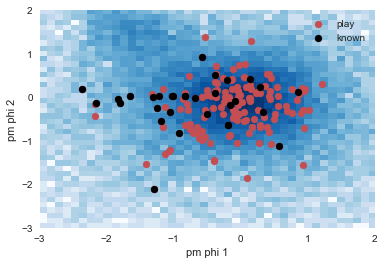

In [37]:
H, xe, ye = np.histogram2d(orphPan.pm_phi1_cosphi2, 
                           orphPan.pm_phi2, 
                           bins=50, range=[[-3, 3],[-3, 3]])
GH = gaussian_filter(H, sigma=0.5)
plt.pcolormesh(xe, ye, H.T+1, norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))

#plt.scatter(orphPan.pm_phi1_cosphi2, orphPan.pm_phi2, c=c_all)
plt.scatter(orphPan.pm_phi1_cosphi2[streamPlay], orphPan.pm_phi2[streamPlay], label='play', c=c_play)
plt.scatter(orphAll.pm_phi1_cosphi2, orphAll.pm_phi2, label='known', c= c_known)
plt.legend()
plt.xlabel('pm phi 1')
plt.ylabel('pm phi 2')
plt.xlim(-3, 2)
plt.ylim(-3, 2)

In [38]:
data[wantedRRlyrae][streamPlay]

dist,rrlyrae_ps1_sesar_etal_oid,ra_1,dec_1,solution_id,designation,source_id,random_index,ref_epoch,ra_1a,ra_error,dec_1a,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,RA_2,DEC_2,RRab,RRc,DM,P,phi0,Ag,Ar,Ai,Az,gmag,rmag,imag,zmag,Tg,Tr,Ti,Tz,gemean,rmean,iman,zmean,EB-V,Separation
,,,,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,solRad,solRad,solRad,solLum,solLum,solLum,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec
float64,int32,float64,float64,int64,bytes28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,bytes13,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,bytes77,bytes99,float64,float64,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float64
5.78082622383e-05,204106,180.31059,-27.5024,1635721458409799680,Gaia DR2 3486702520166938240,3486702520166938240,705449458,2015.5,180.31054708849388,0.21987099332286575,-27.50244350941502,0.1455534147288607,0.3646812219075896,0.3068522661996852,1.18846,-0.418829039551861,0.43836499094741316,0.4350581438084367,0.2382925607541425,-0.101841,-0.199788,-0.384808,-0.249023,-0.0767033,-0.309795,-0.12159,0.277188,0.0878773,-0.11717,377,0,377,0,2.57743,446.072,0.4022803549309561,0.55774246683,31,False,0.24061790108680725,1.6628615723569575,0.05021248882968634,0.0242667,43,13,0.40665701031684875,0,50,False,430,441.9215121700637,3.5904596432461244,123.082,19.075002670288086,48,260.1832007449667,9.613681021791685,27.0638,19.313190460205078,47,283.8371189788378,6.243382649171563,45.4621,18.629247665405273,1.23103,0,0.6839427

Text(0,0.5,'g [panstarrs]')

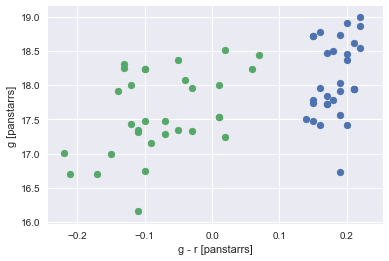

In [375]:
plt.scatter(data[wantedRRlyrae][idx]['gemean'] - data[wantedRRlyrae][idx]['rmean'],
           data[wantedRRlyrae][idx]['rmean'])
plt.scatter(data[wantedRRlyrae][idx]['gmag'] - data[wantedRRlyrae][idx]['rmag'],
           data[wantedRRlyrae][idx]['rmag'])
plt.xlabel('g - r [panstarrs]')
plt.ylabel('g [panstarrs]')

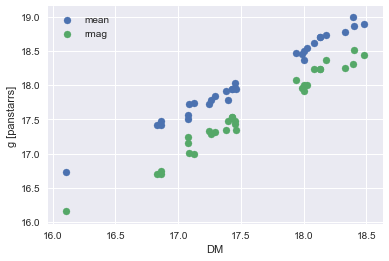

In [377]:
plt.scatter(data[wantedRRlyrae][idx]['DM'],
           data[wantedRRlyrae][idx]['rmean'], label='mean')
plt.scatter(data[wantedRRlyrae][idx]['DM'],
           data[wantedRRlyrae][idx]['rmag'], label = 'rmag')
plt.xlabel('DM')
plt.ylabel('g [panstarrs]')
plt.legend()

do same thing for gd1 

to get BHB, use gaia photometry, blue distant color cut, orphan should light up 

## Query Gaia for BHB stars around Orphan

In [39]:
import os
from os import path
import warnings
from astroquery.gaia import Gaia

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [40]:
data_path = 'orphan-data'
if not path.exists(data_path):
    os.makedirs(data_path)

In [41]:
Gaia.login(user='lander01', password='EsaGaia1234!')

In [42]:
q_base = '''SELECT *
FROM gaiadr2.gaia_source
WHERE parallax < 1 AND bp_rp < 0.75 AND 
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       {0[0].ra.degree}, {0[0].dec.degree}, 
                       {0[1].ra.degree}, {0[1].dec.degree}, 
                       {0[2].ra.degree}, {0[2].dec.degree}, 
                       {0[3].ra.degree}, {0[3].dec.degree})) = 1'''

queries = []
jobs = []
for l in np.arange(-60, 60, 10):
    print(l)
    
    fn = path.join(data_path, 'Orphan-{0}-result.fits.gz'.format(l))
    if path.exists(fn):
        print('{0} exists...skipping'.format(fn))
        continue
    
    corners = gc.Orphan(phi1=[l, l, l+10, l+10]*u.deg, 
                        phi2=[-5, 10, 10, -5]*u.deg)
    corners_icrs = corners.transform_to(coord.ICRS)
    q = q_base.format(corners_icrs)
        
    print(q)
    
    # remove the line below here when you're ready to execute the queries!
    break
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        job = Gaia.launch_job_async(q, name='Orphan-{0}'.format(l), 
                                    background=True)
    jobs.append(job)

-60
orphan-data/Orphan--60-result.fits.gz exists...skipping
-50
orphan-data/Orphan--50-result.fits.gz exists...skipping
-40
orphan-data/Orphan--40-result.fits.gz exists...skipping
-30
orphan-data/Orphan--30-result.fits.gz exists...skipping
-20
orphan-data/Orphan--20-result.fits.gz exists...skipping
-10
orphan-data/Orphan--10-result.fits.gz exists...skipping
0
orphan-data/Orphan-0-result.fits.gz exists...skipping
10
orphan-data/Orphan-10-result.fits.gz exists...skipping
20
orphan-data/Orphan-20-result.fits.gz exists...skipping
30
orphan-data/Orphan-30-result.fits.gz exists...skipping
40
orphan-data/Orphan-40-result.fits.gz exists...skipping
50
orphan-data/Orphan-50-result.fits.gz exists...skipping


In [104]:
for l in np.arange(-60, 60, 10):   
    fn = path.join(data_path, 'Orphan-{0}-result.fits.gz'.format(l))
    t = Table.read(fn)
    try:
        OTable = vstack((OTable, t))
    except NameError:
        OTable = t
    print(len(OTable))

83472


109929


145496


179650


211003


240644


269019


301595


343409


397874


460663
530535


In [212]:
c = coord.SkyCoord(ra=OTable['ra'], dec=OTable['dec'], 
                   pm_ra_cosdec = OTable['pmra'],
                  pm_dec = OTable['pmdec'])
orphQ = c.transform_to(gc.Orphan)

Text(0.5,0,'AG')

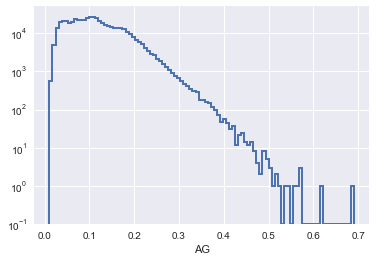

In [271]:
from dustmaps.sfd import SFDQuery
sfd = SFDQuery()
sfd_ebv = sfd(c)
AG, Abp, Arp = getDust(OTable['phot_g_mean_mag'], OTable['phot_bp_mean_mag'], 
               OTable['phot_rp_mean_mag'], sfd_ebv)
plt.hist(AG, bins=100, histtype='step', log=True, linewidth=2)
plt.xlabel('AG')

Text(0.5,0,'AG')

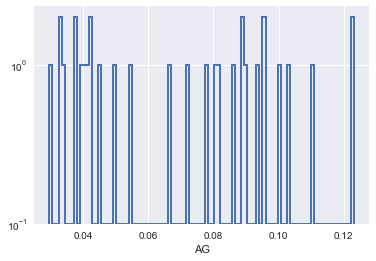

In [308]:
sfd_ebv_all = sfd(cAll)
AGall, Abpall, Arpall = getDust(data[wantedRRlyrae][idx]['phot_g_mean_mag'].value, 
                                data[wantedRRlyrae][idx]['phot_bp_mean_mag'].value, 
                                data[wantedRRlyrae][idx]['phot_rp_mean_mag'].value, sfd_ebv_all)
plt.hist(AGall, bins=100, histtype='step', log=True, linewidth=2)
plt.xlabel('AG')

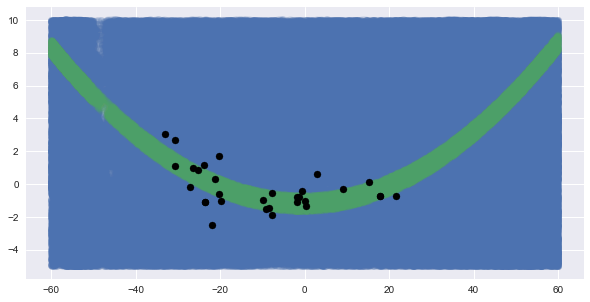

In [304]:
plt.figure(figsize=(10, 5))
plt.plot(orphQ.phi1.wrap_at(180*u.deg), orphQ.phi2, 'o',  alpha=0.1)
streamPlayQuery = (np.abs(f2phi2(orphQ.phi1.wrap_at(180*u.deg)) - orphQ.phi2.value) < 0.5)
plt.plot(orphQ.phi1[streamPlayQuery].wrap_at(180*u.deg), orphQ.phi2[streamPlayQuery], 'o', alpha=0.1)
plt.scatter(orphAll.phi1.wrap_at(180*u.deg), orphAll.phi2, c='black', zorder=10)


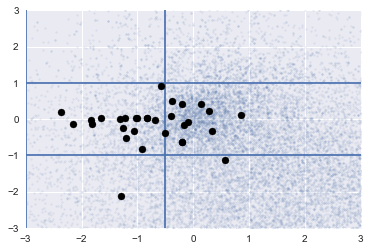

In [366]:
plt.scatter(orphQ.pm_phi1_cosphi2[streamPlayQuery],
           orphQ.pm_phi2[streamPlayQuery], alpha=0.1, s=3)
plt.scatter(orphAll.pm_phi1_cosphi2, orphAll.pm_phi2, c='black', zorder=10)

plt.xlim(-3, 3)
plt.ylim(-3, 3)
pmphi1max = -0.5; pmphi1min = -3; pmphi2max = 1
plt.axhline(pmphi2max)
plt.axhline(-pmphi2max)
plt.axvline(pmphi1min)
plt.axvline(pmphi1max)
pmcut = (orphQ.pm_phi1_cosphi2.value < pmphi1max) & \
        (orphQ.pm_phi1_cosphi2.value > pmphi1min) & \
        (np.abs(orphQ.pm_phi2.value) < pmphi2max)


(0, 1)

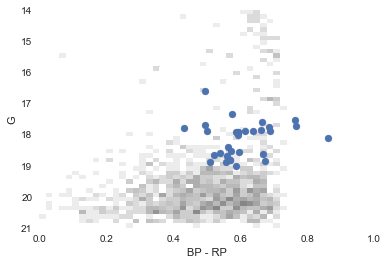

In [369]:
H, xe, ye = np.histogram2d((OTable['bp_rp'] - Abp + Arp)[streamPlayQuery & pmcut], 
                           (OTable['phot_g_mean_mag']-AG)[streamPlayQuery & pmcut], 
                           bins=50, range=[[0, 1],[14, 21]])
plt.pcolormesh(xe, ye, H.T+1, norm=mpl.colors.LogNorm(vmax=100))
plt.gca().invert_yaxis()
plt.scatter(data[wantedRRlyrae][idx]['bp_rp'].value - Abpall + Arpall, 
            data[wantedRRlyrae][idx]['phot_g_mean_mag'].value - AGall)
plt.xlabel('BP - RP')
plt.ylabel('G')
plt.xlim(0, 1)

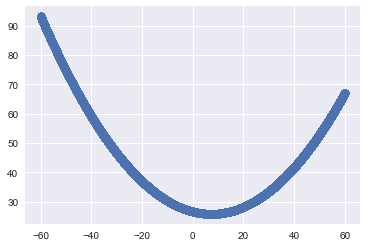

In [378]:
distanceOTable = f2d(orphQ.phi1.wrap_at(180*u.deg))
plt.scatter(orphQ.phi1.wrap_at(180*u.deg), d)



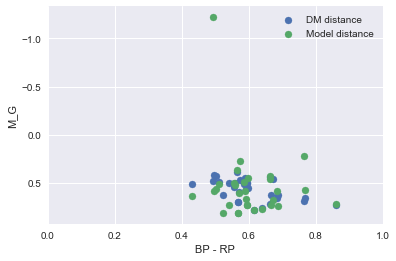

In [380]:
plt.gca().invert_yaxis()
plt.scatter(data[wantedRRlyrae][idx]['bp_rp'].value - Abpall + Arpall, 
            data[wantedRRlyrae][idx]['phot_g_mean_mag'].value - AGall - data[wantedRRlyrae][idx]['DM'],
           label='DM distance')
plt.scatter(data[wantedRRlyrae][idx]['bp_rp'].value - Abpall + Arpall, 
            data[wantedRRlyrae][idx]['phot_g_mean_mag'].value - AGall - 5.*np.log10(f2d(orphAll.phi1.wrap_at(180*u.deg))*100),
           label = 'Model distance')

plt.xlabel('BP - RP')
plt.ylabel('M_G')
plt.xlim(0, 1)
plt.legend()

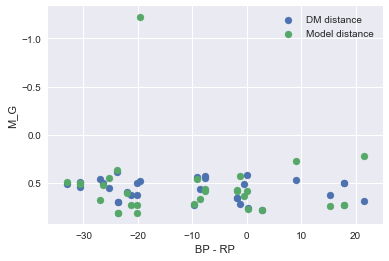

In [383]:
plt.gca().invert_yaxis()
plt.scatter(orphAll.phi1.wrap_at(180*u.deg), 
            data[wantedRRlyrae][idx]['phot_g_mean_mag'].value - AGall - data[wantedRRlyrae][idx]['DM'],
           label='DM distance')
plt.scatter(orphAll.phi1.wrap_at(180*u.deg), 
            data[wantedRRlyrae][idx]['phot_g_mean_mag'].value - AGall - 5.*np.log10(f2d(orphAll.phi1.wrap_at(180*u.deg))*100),
           label = 'Model distance')

plt.xlabel('BP - RP')
plt.ylabel('M_G')
plt.legend()

Text(0,0.5,'Model Distance')

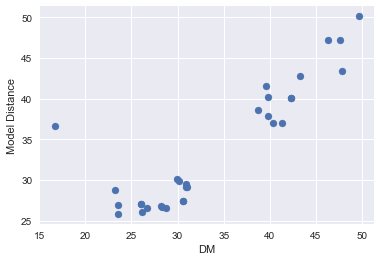

In [389]:
plt.scatter(10.**(data[wantedRRlyrae][idx]['DM']/5.)/100, f2d(orphAll.phi1.wrap_at(180*u.deg)))
plt.xlabel('DM')
plt.ylabel('Model Distance')

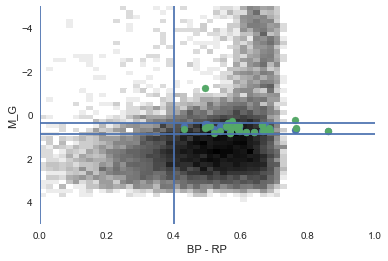

In [382]:
#plt.scatter(OTable['bp_rp'], OTable['phot_g_mean_mag'], alpha=0.1)
playAbsG = OTable['phot_g_mean_mag']-AG - 5.*np.log10(distanceOTable*100)

H, xe, ye = np.histogram2d((OTable['bp_rp'] - Abp + Arp)[pmcut], 
                           (playAbsG)[pmcut], 
                           bins=50, range=[[0, 1],[-5, 5]])
plt.pcolormesh(xe, ye, H.T+1, norm=mpl.colors.LogNorm(vmax=100))

#plt.scatter((OTable['bp_rp'] - Abp + Arp)[streamPlayQuery & pmcut], 
#                           (OTable['phot_g_mean_mag']-AG)[streamPlayQuery & pmcut], s=3)
#plt.colorbar()
plt.gca().invert_yaxis()
plt.scatter(data[wantedRRlyrae][idx]['bp_rp'].value - Abpall + Arpall, 
            data[wantedRRlyrae][idx]['phot_g_mean_mag'].value - AGall - data[wantedRRlyrae][idx]['DM'])
plt.scatter(data[wantedRRlyrae][idx]['bp_rp'].value - Abpall + Arpall, 
            data[wantedRRlyrae][idx]['phot_g_mean_mag'].value - AGall - 5.*np.log10(f2d(orphAll.phi1.wrap_at(180*u.deg))*100))

plt.xlabel('BP - RP')
plt.ylabel('M_G')
plt.xlim(0, 1)
maxG = 0.85; minG = 0.35; maxbprp = 0.4; minbprp = 0.0
plt.axhline(maxG)
plt.axhline(minG)
plt.axvline(maxbprp)
plt.axvline(minbprp)

In [373]:
hbstars = (playAbsG > minG) & \
          (playAbsG < maxG) & \
          ((OTable['bp_rp'] - Abp + Arp) < maxbprp) & \
          ((OTable['bp_rp'] - Abp + Arp) > minbprp)


(-5, 10)

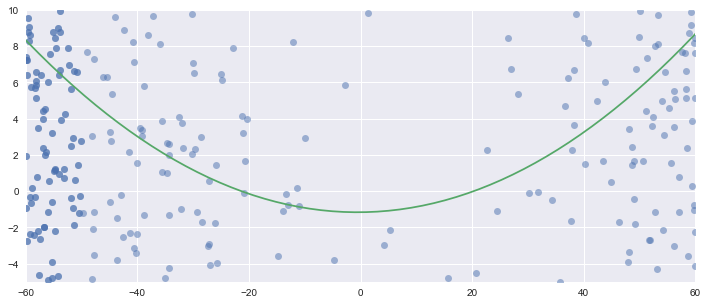

In [374]:
plt.figure(figsize=(12, 5))
plt.plot(orphQ.phi1[hbstars&pmcut].wrap_at(180*u.deg), orphQ.phi2[hbstars&pmcut], 'o', alpha=0.5)
plt.plot(xphi1, f2phi2(xphi1))
plt.xlim(-60, 60)
plt.ylim(-5, 10)

## Maybe use panstarrs photometry?

Text(0,0.5,'Reduced PM')

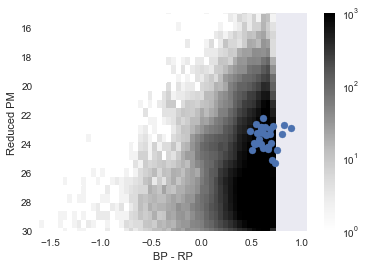

In [214]:
#plt.scatter(OTable['bp_rp'], OTable['phot_g_mean_mag'], alpha=0.1)
mu = np.sqrt(OTable['pmra']**2 + OTable['pmdec']**2)
reducedpm = OTable['phot_g_mean_mag']-AG + 5 + 5*np.log10(mu)
color = OTable['bp_rp'] - Abp + Arp
H, xe, ye = np.histogram2d(color[streamPlayQuery], 
                           reducedpm[streamPlayQuery], 
                           bins=50)
GH = gaussian_filter(H, sigma=0.5)
plt.pcolormesh(xe, ye, H.T+1, norm=mpl.colors.LogNorm(vmax=1e3))
plt.colorbar()
plt.ylim(30, 15)
#plt.gca().invert_yaxis()
mudata = np.sqrt(data[wantedRRlyrae][idx]['pmra'].value**2 + data[wantedRRlyrae][idx]['pmdec'].value**2)
plt.scatter(data[wantedRRlyrae][idx]['bp_rp'], data[wantedRRlyrae][idx]['phot_g_mean_mag'].value + 5 + 5*np.log10(mudata))
plt.xlabel('BP - RP')
plt.ylabel('Reduced PM')
#plt.axhline(23)
#plt.axhline(25)
#plt.axvline(-0.1)
#plt.axvline(0.3)

In [132]:
hbstars = (OTable['phot_g_mean_mag']-AG > 16) & \
          (OTable['phot_g_mean_mag']-AG < 18.5) & \
          (OTable['bp_rp'] - Abp + Arp < 0.3) & \
          (OTable['bp_rp'] - Abp + Arp > -0.25)


hbstars = (reducedpm > 23)  & (reducedpm < 25) & (color > -0.1) & (color < 0.3)

In [86]:
nopes = [coord.SkyCoord.from_name('ngc 2403')]
nope_mask = np.all([nope.separation(c) > 1*u.deg for nope in nopes], axis=0)

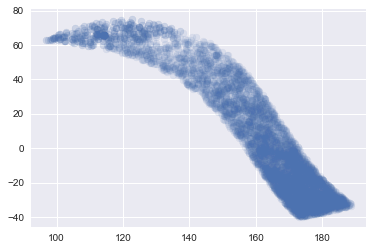

In [133]:
plt.scatter(OTable['ra'][hbstars], OTable['dec'][hbstars], alpha=0.1)


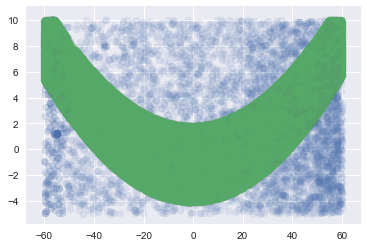

In [141]:
plt.scatter(orphQ.phi1[hbstars], orphQ.phi2[hbstars], alpha=0.1)
plt.scatter(orphQ.phi1[streamPlayQuery], orphQ.phi2[streamPlayQuery], alpha=0.1)

In [46]:
OTable.keys()

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source',
 'phot_g_n_ob

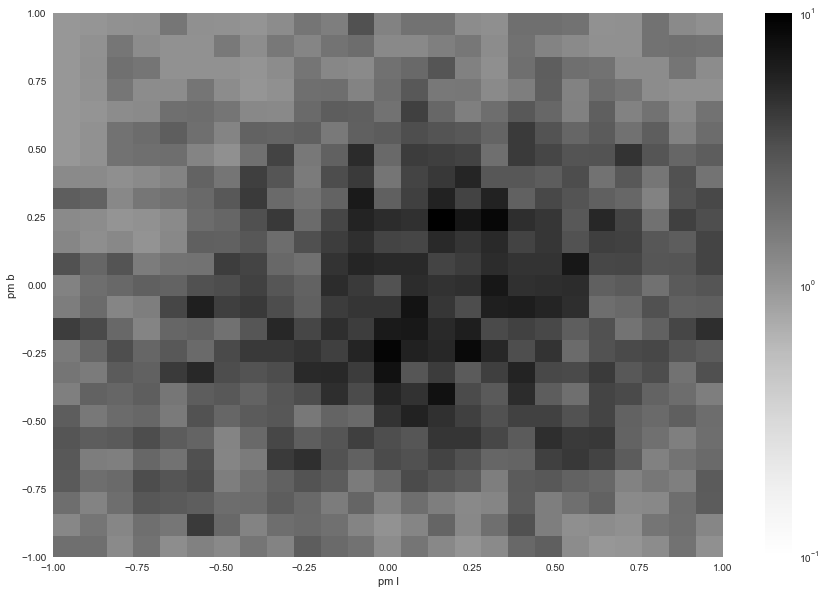

In [476]:
plt.figure(figsize=(15, 10))
H, xe, ye = np.histogram2d(cGalactic.pm_l_cosb[stream], 
                           cGalactic.pm_b[stream], 
                           bins=25, range=[[-1, 1],[-1, 1]])
GH = gaussian_filter(H, sigma=0.5)
plt.pcolormesh(xe, ye, GH.T+1, norm=mpl.colors.LogNorm(vmin=1e-1))
plt.xlabel('pm l')
plt.ylabel('pm b')
plt.colorbar()


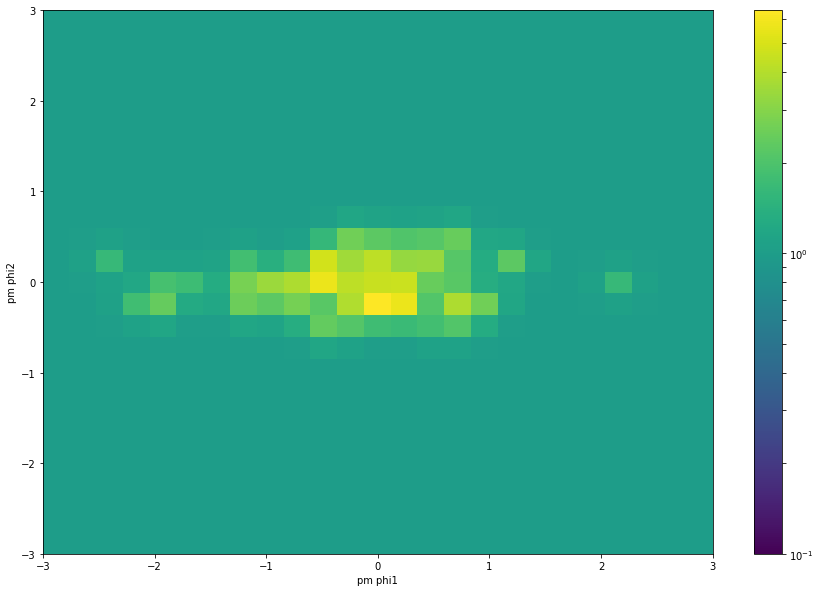

In [29]:
plt.figure(figsize=(15, 10))
H, xe, ye = np.histogram2d(cOrph.pm_phi1_cosphi2[stream], 
                           cOrph.pm_phi2[stream], 
                           bins=25, range=[[-3, 3],[-3, 3]])
GH = gaussian_filter(H, sigma=0.5)
plt.pcolormesh(xe, ye, GH.T+1, norm=mpl.colors.LogNorm(vmin=1e-1))
plt.xlabel('pm phi1')
plt.ylabel('pm phi2')
plt.colorbar()


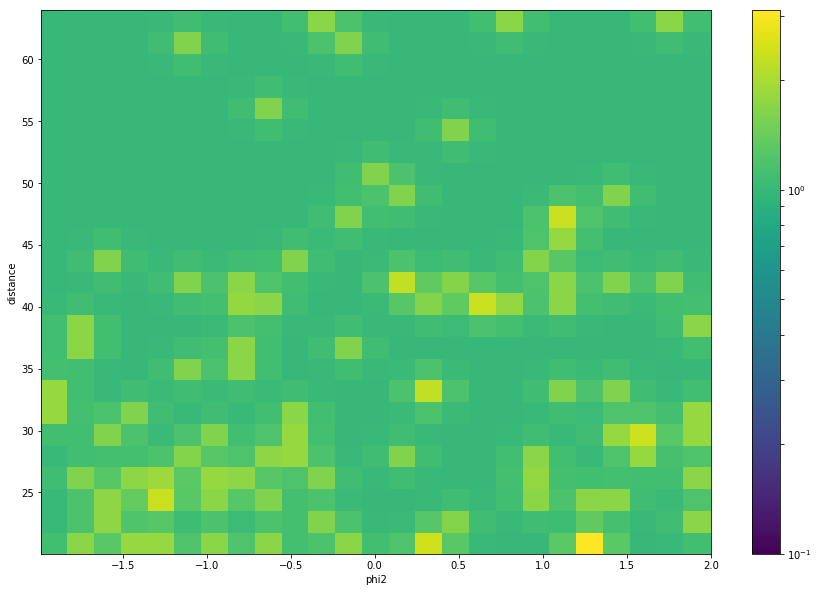

In [30]:
plt.figure(figsize=(15, 10))
H, xe, ye = np.histogram2d(cOrph.phi2[stream], 
                           cOrph.distance[stream], 
                           bins=25) #, range=[[-3, 3],[-3, 3]])
GH = gaussian_filter(H, sigma=0.5)
plt.pcolormesh(xe, ye, GH.T+1, norm=mpl.colors.LogNorm(vmin=1e-1))
plt.xlabel('phi2')
plt.ylabel('distance')
plt.colorbar()


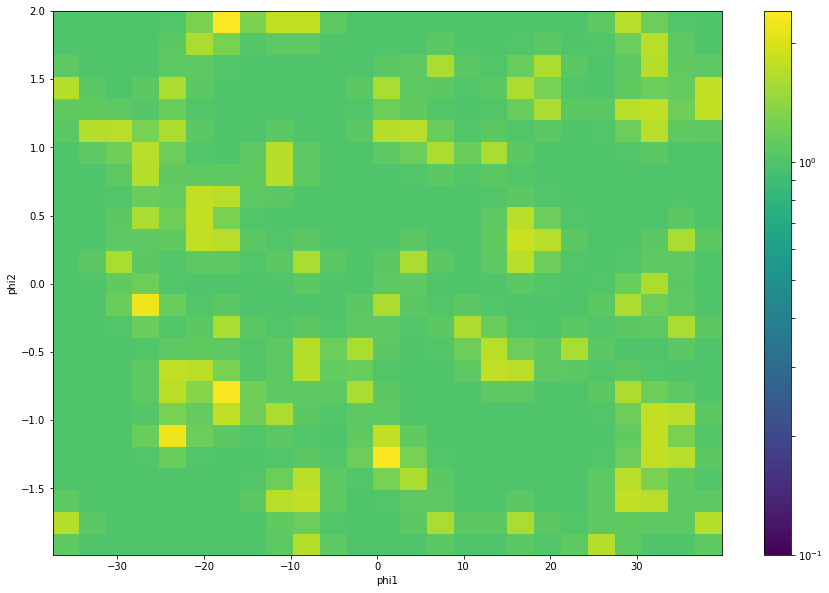

In [32]:
plt.figure(figsize=(15, 10))
H, xe, ye = np.histogram2d(cOrph.phi1[stream].wrap_at(180*u.deg), 
                           cOrph.phi2[stream], 
                           bins=25) #, range=[[-3, 3],[-3, 3]])
GH = gaussian_filter(H, sigma=0.5)
plt.pcolormesh(xe, ye, GH.T+1, norm=mpl.colors.LogNorm(vmin=1e-1))
plt.xlabel('phi1')
plt.ylabel('phi2')
plt.colorbar()


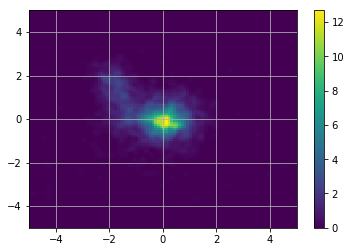

In [91]:
phi1min = 0*u.deg
phi1max = 360*u.deg
phi2max = 5*u.deg
phi2min = 0*u.deg
deltapm = 0.1
deltaphi = 0.5
dpm1 = 5
dpm2 = 5
pm1_edges = np.arange(-dpm1, dpm1+0.001, deltapm)
pm2_edges = np.arange(-dpm2, dpm2+0.001, deltapm)

H, xedges, yedges = np.histogram2d(cOrph.pm_phi1_cosphi2[stream].value,
                               cOrph.pm_phi2[stream].value,
                               bins=[pm1_edges, pm2_edges])
Hback, xeback, yeback     = np.histogram2d(cOrph.pm_phi1_cosphi2[offstream].value,
                               cOrph.pm_phi2[offstream].value,
                               bins=[pm1_edges, pm2_edges])

phi1_edges = np.arange(phi1min.value, phi1max.value+0.001, deltaphi)
phi2_edges = np.arange(-phi2max.value, phi2max.value+0.001, deltaphi)

histSig_pos, xe, ye  = np.histogram2d(cOrph.phi1[stream].value,
                                      cOrph.phi2[stream].value,
                                      bins=[phi1_edges, phi2_edges])

histBack_pos, xe, ye = np.histogram2d(cOrph.phi1[offstream].value,
                                      cOrph.phi2[offstream].value,
                                      bins=[phi1_edges, phi2_edges])


ycenters = (yedges[1:] + yedges[:-1])*0.5
xcenters = (xedges[1:] + xedges[:-1])*0.5
ybackcenters = (yeback[1:] + yeback[:-1])*0.5


areaNorm = np.sum(histSig_pos > 0)/np.float(np.sum(histBack_pos > 0))
finalhist = gaussian_filter(H - Hback*areaNorm, sigma=1.0)
plt.pcolormesh(xedges, yedges, finalhist.T, vmin=0)
plt.colorbar()
plt.grid()

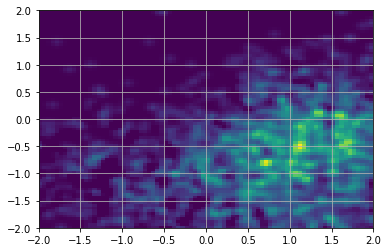

In [86]:
phi1min = 0*u.deg
phi1max = 360*u.deg
phi2max = 5*u.deg
phi2min = 0*u.deg
deltapm = 0.05
deltaphi = 0.5
dpm1 = 2
dpm2 = 2
pm1_edges = np.arange(-dpm1, dpm1+0.001, deltapm)
pm2_edges = np.arange(-dpm2, dpm2+0.001, deltapm)

H, xedges, yedges = np.histogram2d(cGal_noc.pm_l_cosb[stream].value,
                               cGal_noc.pm_b[stream].value,
                               bins=[pm1_edges, pm2_edges])
Hback, xeback, yeback     = np.histogram2d(cGal_noc.pm_l_cosb[offstream].value,
                               cGal_noc.pm_b[offstream].value,
                               bins=[pm1_edges, pm2_edges])

phi1_edges = np.arange(phi1min.value, phi1max.value+000.1, deltaphi)
phi2_edges = np.arange(-phi2max.value, phi2max.value+000.1, deltaphi)

histSig_pos, xe, ye  = np.histogram2d(cOrph.phi1[stream].value,
                                      cOrph.phi2[stream].value,
                                      bins=[phi1_edges, phi2_edges])

histBack_pos, xe, ye = np.histogram2d(cOrph.phi1[offstream].value,
                                      cOrph.phi2[offstream].value,
                                      bins=[phi1_edges, phi2_edges])


ycenters = (yedges[1:] + yedges[:-1])*0.5
xcenters = (xedges[1:] + xedges[:-1])*0.5
ybackcenters = (yeback[1:] + yeback[:-1])*0.5


areaNorm = np.sum(histSig_pos > 0)/np.float(np.sum(histBack_pos > 0))
finalhist = gaussian_filter(H - Hback*areaNorm, sigma=1.0)
plt.pcolormesh(xedges, yedges, finalhist.T, vmin=0)
plt.grid()

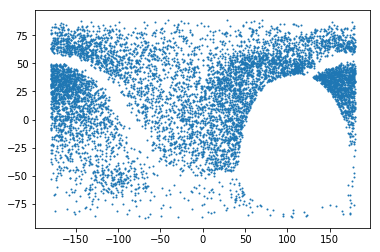

In [77]:
streampm = (np.abs(cOrph.pm_phi1_cosphi2 - 0.125*u.mas/u.yr).value < 10) & \
           (np.abs(cOrph.pm_phi2).value < 0.25)
plt.scatter(cOrph.phi1[streampm].wrap_at(180*u.deg), cOrph.phi2[streampm].wrap_at(180*u.deg), s=1)